# 18-13. 프로젝트: 뉴스기사 요약해보기

## Step 1. 데이터 수집하기

In [47]:
# 도구 준비
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/aiffel0042/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98401


In [3]:
data.sample(10)

,headlines,text
39136,K'taka CM Kumaraswamy keeps 11 ministries incl...,Karnataka CM HD Kumaraswamy has allotted himse...
55693,US lifts funding ban on research to make virus...,The US government has lifted a three-year fund...
43823,Indian holds world record for memorising most ...,"In October 2015, Jaipur's Suresh Kumar Sharma ..."
76838,India to witness partial lunar eclipse on Augu...,"A lunar eclipse will occur on August 7 night, ..."
65219,"Talwars donate Ã¢ÂÂ¹98,000 earned in jail to ...","Aarushi Talwar's parents had earned Ã¢ÂÂ¹49,0..."
87248,Girls should avoid places where they can be mo...,Uttar Pradesh MLA and veteran Samajwadi Party ...
67757,US cuts embassy staff in Cuba amid sonic attacks,The US is withdrawing more than half of its di...
75834,Pahlaj Nihalani fired as India's Censor Board ...,The Ministry of Information & Broadcasting has...
83036,Jayant Sinha likens GST launch to 'happy India...,Likening the roll-out of GST to an Indian wedd...
14823,"Govt cuts petrol, diesel prices by Ã¢ÂÂ¹2.50 ...",The central government has cut the prices of p...


## Step 2. 데이터 전처리하기 (추상적 요약)

실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해보세요.

In [4]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


headlines에서 중복되는 경우가 80개가 발견되었다. 그러나 본문의 중복건수는 0건이기 때문에 우연의 일치로 제목이 동일하게 달린것으로 판단한다.

In [5]:
data.drop_duplicates(subset = ['text'], inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98360


In [6]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


news article에서 사용되는 contraction은 상대적으로 적은 편이다. ain't같은 비문은 사용되지 않기도 하고 I, you 같은 주어의 빈도가 일상대화에 비해 빈도가 낮은 편이기도 하다. 물론 여전히 연산을 줄이기 위한 사전을 갖춰야할 필요성은 있다. 다만 중복 연산되는 것은 contraction 이외에도 US, U.S.A, USA, America 등 동의어가 존재하며 fomal writing에선 같은 어휘를 반복사용하는 것을 지양하여 동의어, 유의어를 적극적으로 활용하기 때문에 이를 고려해야한다. 그러나 이 작업에는 많은 시간이 소요되기 때문에 본 노드에서는 따로 제작하지 않고 NLTK에서 제공하는 불용어만을 제거하겠다. summary에선 해당 작업을 진행하지 않는다.

In [7]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ",len(contractions))

정규화 사전의 수:  120


In [8]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [9]:
#데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [10]:
#정규화 확인
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


In [11]:
clean_text = []

for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
clean_text[:5]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

In [12]:
clean_summary = []

for s in data['headlines']:
    clean_summary.append(preprocess_sentence(s, False))

clean_summary[:5]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

In [13]:
data['text'] = clean_text
data['headlines'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [14]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


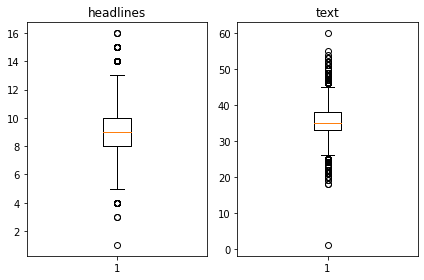

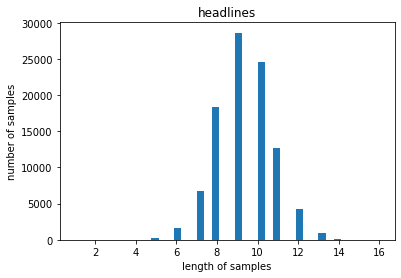

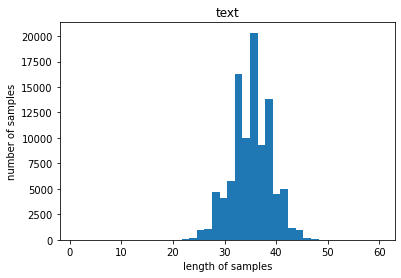

In [15]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [16]:
text_max_len = 60
summary_max_len = 12

In [17]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [18]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(summary_max_len,  data['headlines'])

전체 샘플 중 길이가 60 이하인 샘플의 비율: 1.0
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9880337535583571


In [19]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 97183


In [20]:
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...


In [21]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [22]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[ 4152 12797 12371 ... 81499 53748 79652]


In [23]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [24]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 19436


In [25]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 77747
훈련 레이블의 개수 : 77747
테스트 데이터의 개수 : 19436
테스트 레이블의 개수 : 19436


In [26]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [27]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69478
등장 빈도가 6번 이하인 희귀 단어의 수: 47400
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22078
단어 집합에서 희귀 단어의 비율: 68.22303462966694
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.5197228248503527


In [35]:
src_vocab = 22000
src_tokenizer = Tokenizer(num_words = src_vocab)
src_tokenizer.fit_on_texts(encoder_input_train)

In [36]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

#잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[151, 15, 112, 47, 57, 1046, 36, 1642, 1062, 266, 147, 10, 290, 830, 350, 8, 21, 8, 3358, 424, 350, 830, 1, 7035, 266, 38, 5560, 539, 49, 47, 1, 10, 39, 4297, 5831], [124, 845, 93, 536, 247, 981, 142, 2, 83, 968, 778, 2, 85, 22, 1, 2156, 9405, 968, 142, 4035, 54, 85, 127, 692, 33, 5832, 142, 2, 410, 700, 6836, 968, 142, 635, 5200, 2], [436, 15, 4062, 48, 2582, 57, 1, 4430, 3569, 448, 910, 101, 304, 14718, 5894, 3076, 4142, 148, 2461, 1666, 910, 4, 2582, 155, 4062, 2549, 267, 46, 3023, 1, 287, 910]]


In [37]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [38]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30068
등장 빈도가 5번 이하인 희귀 단어의 수: 19757
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10311
단어 집합에서 희귀 단어의 비율: 65.70772914726619
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.750401970596572


In [39]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 319, 23, 983, 1940, 221, 820, 22, 39], [1, 413, 8, 11, 9, 2153, 198, 634, 34], [1, 427, 32, 6778, 11, 1361, 7, 217, 6137], [1, 525, 8744, 1157, 6, 220, 30, 1822, 8745], [1, 4100, 170, 3988, 15, 45, 2541, 5, 2332, 56, 3295]]
target
decoder  [[319, 23, 983, 1940, 221, 820, 22, 39, 2], [413, 8, 11, 9, 2153, 198, 634, 34, 2], [427, 32, 6778, 11, 1361, 7, 217, 6137, 2], [525, 8744, 1157, 6, 220, 30, 1822, 8745, 2], [4100, 170, 3988, 15, 45, 2541, 5, 2332, 56, 3295, 2]]


In [40]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 77746
훈련 레이블의 개수 : 77746
테스트 데이터의 개수 : 19436
테스트 레이블의 개수 : 19436


In [41]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = summary_max_len, padding='post')

## Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)

In [48]:
# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [49]:
# 디코더 설계

decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [50]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 128)      2816000     input_2[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [51]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 128)      2816000     input_2[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [52]:
# 모델 훈련

model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Epoch 1/50
304/304 [==============================] - 125s 412ms/step - loss: 5.6026 - val_loss: 5.1825
Epoch 2/50
304/304 [==============================] - 128s 420ms/step - loss: 5.0283 - val_loss: 4.8233
Epoch 3/50
304/304 [==============================] - 132s 433ms/step - loss: 4.7031 - val_loss: 4.5555
Epoch 4/50
304/304 [==============================] - 123s 405ms/step - loss: 4.4423 - val_loss: 4.3538
Epoch 5/50
304/304 [==============================] - 125s 410ms/step - loss: 4.2328 - val_loss: 4.2110
Epoch 6/50
304/304 [==============================] - 123s 404ms/step - loss: 4.0619 - val_loss: 4.1009
Epoch 7/50
304/304 [==============================] - 122s 400ms/step - loss: 3.9169 - val_loss: 4.0199
Epoch 8/50
304/304 [==============================] - 121s 399ms/step - loss: 3.7922 - val_loss: 3.9344
Epoch 9/50
304/304 [==============================] - 119s 392ms/step - loss: 3.6823 - val_loss: 3.8743
Epoch 10/50
304/304 [==============================] - 120s 395m

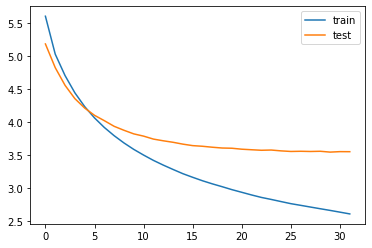

In [53]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

In [54]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [55]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [56]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [57]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [58]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [59]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

실제 요약 : maharashtra government to buy chopper for vips 
예측 요약 :  maharashtra to air india to give fighter jet air


실제 요약 : rafael nadal clinches record th barcelona open title 
예측 요약 :  nadal wins th title of the year in st of the


실제 요약 : asteroid with similar orbit as jupiter sun 
예측 요약 :  scientists discover new asteroid by sun


실제 요약 : not on my agenda right now varun on rumours of his marriage 
예측 요약 :  it is not single wedding jacqueline on rumoured girlfriend


실제 요약 : cash with public doubles since note ban to record tn 
예측 요약 :  currency inflation hits record high of in


실제 요약 : mob attacks men transporting dead buffalo in uttar pradesh 
예측 요약 :  mob lynching police attacked by mob in up


실제 요약 : china pak increasing fleet we must jets sitharaman 
예측 요약 :  india should not be allowed to make defence defence minister


실제 요약 : award winning photo disqualified judges say animal is fake 
예측 요약 :  uk museum named new year award for


실제 요약 : to play villain in new spider man 

키워드 면에선 어느정도 비슷한 면을 뽑아내는 것을 확인할 수 있지만 문법적으로 맞지 않는 경우가 대다수며 이를 개선해줄 추가적인 모듈이 필요하다.

## Step 5. Summa을 이용해서 추출적 요약해보기

In [60]:
from summa.summarizer import summarize

In [64]:
for i in range(10, 20):
#    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("Abstractive 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("Extractive 요약 :", summarize(seq2text(encoder_input_test[i]), ratio=0.005))
    print("\n")

실제 요약 : muslim family donates its land for temple in bihar 
Abstractive 요약 :  muslims to donate cr to donate land to land
Extractive 요약 : 


실제 요약 : iit bombay students on hunger strike against fee hike 
Abstractive 요약 :  students protest against fee hike in tamil nadu
Extractive 요약 : 


실제 요약 : huma to star opposite rajinikanth in upcoming film reports 
Abstractive 요약 :  huma qureshi to rajinikanth film
Extractive 요약 : 


실제 요약 : protesters spell out in flash mob against trump 
Abstractive 요약 :  protesters use trump to protest against trump leaders
Extractive 요약 : 


실제 요약 : flipkart banned from goods sale under on trademark issue 
Abstractive 요약 :  delhi hc fines delhi based on trademark
Extractive 요약 : 


실제 요약 : only woman has won nobel in economic in years 
Abstractive 요약 :  indian origin woman wins nobel prize prize
Extractive 요약 : 


실제 요약 : touching experience csk lungi on training at local club 
Abstractive 요약 :  csk watson shares video of his physical transformation
Extractiv

추출이 진행되지 않는 문제가 발생했다.

In [122]:
for i in range(100, 150):
    print("Extractive 요약 :", summarize(seq2text(encoder_input_test[i]), ratio = 0.9))
    print("\n")

Extractive 요약 : 


Extractive 요약 : 


Extractive 요약 : 


Extractive 요약 : 


Extractive 요약 : 


Extractive 요약 : 


Extractive 요약 : 


Extractive 요약 : 


Extractive 요약 : 


Extractive 요약 : 


Extractive 요약 : 


Extractive 요약 : 


Extractive 요약 : 


Extractive 요약 : 


Extractive 요약 : 


Extractive 요약 : 


Extractive 요약 : 


Extractive 요약 : 


Extractive 요약 : 


Extractive 요약 : 


Extractive 요약 : 


Extractive 요약 : 


Extractive 요약 : 


Extractive 요약 : 


Extractive 요약 : 


Extractive 요약 : 


Extractive 요약 : 


Extractive 요약 : 


Extractive 요약 : 


Extractive 요약 : 


Extractive 요약 : 


Extractive 요약 : 


Extractive 요약 : 


Extractive 요약 : 


Extractive 요약 : 


Extractive 요약 : 


Extractive 요약 : 


Extractive 요약 : 


Extractive 요약 : 


Extractive 요약 : 


Extractive 요약 : 


Extractive 요약 : 


Extractive 요약 : 


Extractive 요약 : 


Extractive 요약 : 


Extractive 요약 : 


Extractive 요약 : 


Extractive 요약 : 


Extractive 요약 : 


Extractive 요약 : 




In [124]:
text1 = """Automatic summarization is the process of reducing a text document with a \
computer program in order to create a summary that retains the most important points \
of the original document. As the problem of information overload has grown, and as \
the quantity of data has increased, so has interest in automatic summarization. \
Technologies that can make a coherent summary take into account variables such as \
length, writing style and syntax. An example of the use of summarization technology \
is search engines such as Google. Document summarization is another."""

text2 = """indian dairy cooperative amul friday released poster captioned anyone congress mp shashi tharoor tweet word went viral amul small word delicious poster read tharoor tweet writing speaking style received various reactions twitter user tweeting got new farrago"""

In [125]:
print(summarize(text1, ratio = 0.5))

Automatic summarization is the process of reducing a text document with a computer program in order to create a summary that retains the most important points of the original document.
Document summarization is another.


In [128]:
print(summarize(text2, words = 1))

In [132]:
print(summarize(clean_text[1], ratio = 0.9))

장문의 경우 정상적으로 진행되지만 단문의 경우 진행되지 않는 문제가 발생했다. 파라미터를 ratio가 아닌 words로 적용해도 마찬가지였다.

## abstractive 방식과 extractive 방식 비교

extractive 방식은 너무 짧은 경우 추출이 진행되지 않는 경우가 발생했다.

그러나 abstractive 역시 문제가 발생하는데 다음과 같이,

실제 요약 : kerala does not need advice on nationalism from rss cm

예측 요약 :  rss rss trying to rss leader on rss kerala remark

키워드는 어느정도 뽑아내지만 문법적인 면에서 상당히 취약한 것을 확인 할 수 있다.